# POLI/USP Capstone Project
Author: Gabriel Benvegmi

This notebook does the step of data fetching from the B3 (the brazilian stock exchange) website. It gets the published open communications to the market participants, save them as PDFs, and finally converts the PDFs to text and adds them to a Pandas Dataframe.

At the end of the process, some heuristics are calculated in order to find any discrepancies between different Python PDF libraries.

In [85]:
import io
import os
import multiprocessing
import requests
from datetime import date, datetime
from itertools import combinations
from random import randint
from time import sleep

import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from bs4 import BeautifulSoup
from IPython.display import IFrame

In [86]:
def _fetch_page_content(page_num=1):
    """Fetches page content from B3 website."""
    url = f"https://www.b3.com.br/pt_br/regulacao/oficios-e-comunicados/?pagination={page_num}"
    
    # ToDo - retry on except
    try:
        response = requests.get(url)
    except Exception as e:
        raise e
    
    return BeautifulSoup(response.text, 'html.parser')

In [132]:
def _get_pdf_content(url):
    """Helper function to scrape_b3 function."""

    wait = 10
    while True:
        try:
            data = requests.get(url)
        except ConnectionError:
            sleep(wait)
            wait += wait
        break
        
    return data

In [133]:
save_path = "/home/gabriel/Documentos/projects/poli-capstone-project/data/pdf/"
file_list = os.listdir(save_path)

In [134]:
def scrape_b3(page_num):
    """
    Fetches communications from B3 website using BeautifulSoup.
    This function is prepared to work with multiprocessing in order to
    execute faster.
    """
    # This has been added in order to avoid apparent rate limits.
    # Without this, the process would never end, being stuck at some
    # random pagination number
    if page_num % 5 == 0: 
        sleep(randint(0,20))
        
    soup = _fetch_page_content(page_num)
    content_divs = soup.select('li.accordion-navigation')
    
    base_url = "https://www.b3.com.br"
    items = []
    
    # For each published communication
    for content in content_divs:
        published_date = content.select("div.least-content")[0].text
        published_title = content.select("div.content p.primary-text")[0].text
        published_abstract = content.select("div.content p.resumo-oficio")[0].text
        published_subject = content.select("div.content p.assunto-oficio")[0].text
        communication_link = content.select("div.content ul li a")[0].get("href", None)
        
        url = base_url + communication_link
        
        pdf_response = _get_pdf_content(url)
        pdf_bytes = pdf_response.content
    
        file_date = published_date.replace("/", "_")
        file_title = published_title.replace("/", "_")
        file_name = f'{save_path}{file_date}|{file_title}.pdf'
    
        items.append([published_date, published_title, published_abstract, published_subject, url, file_name])
    
        with open(file_name, 'wb') as f:
            f.write(pdf_bytes)
            
        sleep(randint(0,3))
        
    return pd.DataFrame(
        items, 
        columns=[
            "published_date", 
            "published_title", 
            "published_abstract", 
            "published_subject", 
            "url", 
            "file_name"
        ]
    )

In [135]:
num_processes = 4
pagination = [i for i in range(1, 285)] # There are 284 pages as of 2023-10-29

# Rate limiting were being faced when using multiprocessing
# with multiprocessing.Pool(processes=num_processes) as pool:
#     results = list(
#         tqdm.tqdm(
#         pool.imap(scrape_b3, pagination),
#         total=len(pagination)
#         )
#     )

results = []
for idx in pagination:
    print(f"Processing page... {idx}")
    results.append(scrape_b3(idx))

Processing page... 1
Processing page... 2
Processing page... 3
Processing page... 4
Processing page... 5
Processing page... 6
Processing page... 7
Processing page... 8
Processing page... 9
Processing page... 10
Processing page... 11
Processing page... 12
Processing page... 13
Processing page... 14
Processing page... 15
Processing page... 16
Processing page... 17
Processing page... 18
Processing page... 19
Processing page... 20
Processing page... 21
Processing page... 22
Processing page... 23
Processing page... 24
Processing page... 25
Processing page... 26
Processing page... 27
Processing page... 28
Processing page... 29
Processing page... 30
Processing page... 31
Processing page... 32
Processing page... 33
Processing page... 34
Processing page... 35
Processing page... 36
Processing page... 37
Processing page... 38
Processing page... 39
Processing page... 40
Processing page... 41
Processing page... 42
Processing page... 43
Processing page... 44
Processing page... 45
Processing page... 

In [137]:
df = pd.concat(results)
df.head(2)

,published_date,published_title,published_abstract,published_subject,url,file_name
0,09/11/23,187-2023-PRE-Ofício Circular,"Informamos que, a partir de 13/11/2023, inclus...",Alteração na Regra de Cadastro Automático de V...,https://www.b3.com.br/data/files/73/E7/C5/27/2...,/home/gabriel/Documentos/projects/poli-capston...
1,09/11/23,186-2023-PRE-Ofício Circular,"Informamos que, a partir de 27/11/2023, serão ...",Novas Regras e Parâmetros para Procedimentos E...,https://www.b3.com.br/data/files/0F/44/94/03/7...,/home/gabriel/Documentos/projects/poli-capston...


In [138]:
df_replaced = df.assign(
    file_name=df["file_name"].str.replace(save_path, "")
)
df_replaced.head()

,published_date,published_title,published_abstract,published_subject,url,file_name
0,09/11/23,187-2023-PRE-Ofício Circular,"Informamos que, a partir de 13/11/2023, inclus...",Alteração na Regra de Cadastro Automático de V...,https://www.b3.com.br/data/files/73/E7/C5/27/2...,09_11_23|187-2023-PRE-Ofício Circular.pdf
1,09/11/23,186-2023-PRE-Ofício Circular,"Informamos que, a partir de 27/11/2023, serão ...",Novas Regras e Parâmetros para Procedimentos E...,https://www.b3.com.br/data/files/0F/44/94/03/7...,09_11_23|186-2023-PRE-Ofício Circular.pdf
2,09/11/23,109-2023-VNC-Comunicado Externo,"Informamos que, conforme divulgado no Comunica...",Sessão de Negociação Simulada – PUMA Trading S...,https://www.b3.com.br/data/files/81/40/5E/CF/2...,09_11_23|109-2023-VNC-Comunicado Externo.pdf
3,09/11/23,108-2023-VNC-Comunicado Externo,Informamos que as especificações técnicas do D...,EntryPoint – Interface de envio de ordens: nov...,https://www.b3.com.br/data/files/60/F7/D0/49/E...,09_11_23|108-2023-VNC-Comunicado Externo.pdf
4,09/11/23,107-2023-VNC-Comunicado Externo,"A B3 informa que, conforme Comunicado Externo ...",Lançamento das sessões de Renda Fixa Trademate,https://www.b3.com.br/data/files/78/67/00/8C/C...,09_11_23|107-2023-VNC-Comunicado Externo.pdf


# Renaming PDFs

In [139]:
os.chdir(save_path)
file_list = os.listdir()
pdf_file_list = filter(lambda f: f.endswith(".pdf"), file_list)

In [140]:
for f in pdf_file_list: #[:1]:
    split_date = f[:8].split("_")
    
    day = split_date[0]
    month = split_date[1]
    year = "20" + split_date[-1]
    str_parsed = f"{year}-{month}-{day}"

    try:
        datetime_parsed = date(int(year), int(month), int(day))
        new_name = str_parsed + f[8:]
        
        os.rename(f, new_name)
    except Exception as e:
        print(e, f)

In [141]:
# Checkpoint
# df_replaced.to_parquet("/home/gabriel/Documentos/projects/poli-capstone-project/data/b3_pdf_comparison.parquet", engine="pyarrow")

In [161]:
df_replaced = pd.read_parquet("/home/gabriel/Documentos/projects/poli-capstone-project/data/b3_pdf_comparison.parquet", engine="pyarrow")
df_replaced["published_date"] = pd.to_datetime(df_replaced["published_date"], format="%d/%m/%y")

df_replaced.head(2)

,published_date,published_title,published_abstract,published_subject,url,file_name
0,2023-11-09,187-2023-PRE-Ofício Circular,"Informamos que, a partir de 13/11/2023, inclus...",Alteração na Regra de Cadastro Automático de V...,https://www.b3.com.br/data/files/73/E7/C5/27/2...,09_11_23|187-2023-PRE-Ofício Circular.pdf
1,2023-11-09,186-2023-PRE-Ofício Circular,"Informamos que, a partir de 27/11/2023, serão ...",Novas Regras e Parâmetros para Procedimentos E...,https://www.b3.com.br/data/files/0F/44/94/03/7...,09_11_23|186-2023-PRE-Ofício Circular.pdf


In [165]:
# Updating the file names over the dataframe that references them
df_replaced["file_date"] = df_replaced["file_name"].str[:8]
df_replaced["split_date"] = df_replaced["file_date"].str.split("_")

df_replaced["day"] = df_replaced["split_date"].str[0]
df_replaced["month"] = df_replaced["split_date"].str[1]
df_replaced["year"] = "20" + df_replaced["split_date"].str[-1]
df_replaced["str_parsed"] = df_replaced["year"] + "-" + df_replaced["month"] + "-" + df_replaced["day"]

df_replaced["file_name"] = df_replaced["str_parsed"] + df_replaced["file_name"].str[8:]

df_replaced.drop(columns=["file_date", "day", "month", "year", "str_parsed", "split_date"], inplace=True)
df_replaced = df_replaced.sort_values(by=["published_date"], ascending=False)
df_replaced.head()

,published_date,published_title,published_abstract,published_subject,url,file_name
0,2023-11-09,187-2023-PRE-Ofício Circular,"Informamos que, a partir de 13/11/2023, inclus...",Alteração na Regra de Cadastro Automático de V...,https://www.b3.com.br/data/files/73/E7/C5/27/2...,2023-11-09|187-2023-PRE-Ofício Circular.pdf
4,2023-11-09,107-2023-VNC-Comunicado Externo,"A B3 informa que, conforme Comunicado Externo ...",Lançamento das sessões de Renda Fixa Trademate,https://www.b3.com.br/data/files/78/67/00/8C/C...,2023-11-09|107-2023-VNC-Comunicado Externo.pdf
6,2023-11-09,058-2023-VPC-Comunicado Externo,"Informamos que, em 27/10/2023, a Receita Feder...",Imposto de Renda da Pessoa Física (IRPF) – Cál...,https://www.b3.com.br/data/files/43/00/01/01/9...,2023-11-09|058-2023-VPC-Comunicado Externo.pdf
5,2023-11-09,059-2023-VPC-Comunicado Externo,"A B3 informa que, os dados indicados neste Com...",Atualização cadastral de companhias emissoras ...,https://www.b3.com.br/data/files/31/60/A7/FF/A...,2023-11-09|059-2023-VPC-Comunicado Externo.pdf
1,2023-11-09,186-2023-PRE-Ofício Circular,"Informamos que, a partir de 27/11/2023, serão ...",Novas Regras e Parâmetros para Procedimentos E...,https://www.b3.com.br/data/files/0F/44/94/03/7...,2023-11-09|186-2023-PRE-Ofício Circular.pdf


In [167]:
df_replced.to_parquet("/home/gabriel/Documentos/projects/poli-capstone-project/data/list_b3_pdf_comparison.parquet", engine="pyarrow")

In [168]:
df_replaced[["published_date", "published_title", "url", "file_name"]].to_csv("/home/gabriel/Documentos/projects/poli-capstone-project/data/b3_file_list_with_links.csv", index=False)

In [169]:
from pypdf import PdfReader

def extract_text_with_pypdf(dataframe_row):
    save_path = "/home/gabriel/Documentos/projects/poli-capstone-project/data/pdf/"
    file_name = dataframe_row
    
    with open(f'{save_path}{file_name}', "rb") as pdf_file:
        reader = PdfReader(pdf_file)
        pages = reader.pages
        
        full_text = ""
        for page in pages:
          full_text += page.extract_text()

    return full_text

In [170]:
df_replaced['pypdf_extraction'] = df_replaced["file_name"].apply(extract_text_with_pypdf)
df_replaced.tail()

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdf_extraction
5,2017-03-28,023-2017-DP-Ofício Circular,Entrará em vigor a nova Política de Tarifação ...,Política de Tarifação de Opções sobre Índice d...,https://www.b3.com.br/data/files/7E/71/F7/DF/8...,2017-03-28|023-2017-DP-Ofício Circular.pdf,\n \n \n 1 \n28 de março de 2017 \n023/201...
6,2017-03-27,027-2017-DO-Comunicado Externo,Novo arquivo de saldo analítico do Tesouro Dir...,Novo Arquivo de Saldo Analítico do Tesouro Dir...,https://www.b3.com.br/data/files/8C/34/7E/24/D...,2017-03-27|027-2017-DO-Comunicado Externo.pdf,\n \n27 de março de 2017 \n027/2017 -DO \nC...
7,2017-03-27,026-2017-DO-Comunicado Externo,"Em 08/04 e 20/05/2017, serão realizadas sessõe...",Sessões de Negociação Simulada no 2º Trimestre...,https://www.b3.com.br/data/files/AD/F3/01/D8/7...,2017-03-27|026-2017-DO-Comunicado Externo.pdf,\n \n27 de março de 2017 \n026/2017 -DO \nC...
8,2017-03-27,022-2017-DP-Ofício Circular,A Bolsa descontinuará o registro de Certificad...,Plataforma de Registro de Ativos e Derivativos...,https://www.b3.com.br/data/files/12/C5/FE/C5/1...,2017-03-27|022-2017-DP-Ofício Circular.pdf,\n \n \n \n 1 \n \n \n27 de março de 20...
9,2017-03-27,021-2017-DP-Ofício Circular,Passarão a vigorar novas regras para que os Fo...,Regras para Isenção da Taxa de Liquidação e do...,https://www.b3.com.br/data/files/9B/B5/C6/A9/F...,2017-03-27|021-2017-DP-Ofício Circular.pdf,\n \n \n 1 \n27 de março de 2017 \n021/20...


In [172]:
# entries that are empty
df_replaced[df_replaced["pypdf_extraction"].apply(len) <= 5].shape

(22, 7)

In [175]:
df_replaced.to_parquet(f"{save_path}list_b3_pdf_comparison.parquet", engine="pyarrow")

The pdfminer library will be tested. The <a href="https://github.com/euske/pdfminer">main</a> library appear to be dormant currently, and it's recommended in their github page to use <a href="https://github.com/pdfminer/pdfminer.six">pdfminer.six</a>. So, this version will be the tested one.
Also, based on recent benchmarks presented over this benchmarks <a href="https://github.com/py-pdf/benchmarks">repo</a> on Github, pypdfium2 will also be tested, as it's the library that presents the best results over the benchmarks there.

In [176]:
from pdfminer.high_level import extract_text

def extract_text_with_pdfminer(dataframe_row):
    save_path = "/home/gabriel/Documentos/projects/poli-capstone-project/data/pdf/"
    file_name = dataframe_row
    
    full_text = extract_text(f'{save_path}{file_name}')
    return full_text

In [177]:
df_replaced['pdfminer_extraction'] = df_replaced["file_name"].apply(extract_text_with_pdfminer)
df_replaced.tail()

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdf_extraction,pdfminer_extraction
5,2017-03-28,023-2017-DP-Ofício Circular,Entrará em vigor a nova Política de Tarifação ...,Política de Tarifação de Opções sobre Índice d...,https://www.b3.com.br/data/files/7E/71/F7/DF/8...,2017-03-28|023-2017-DP-Ofício Circular.pdf,\n \n \n 1 \n28 de março de 2017 \n023/201...,28 de março de 2017 \n\n023/2017-DP \n\nO F Í ...
6,2017-03-27,027-2017-DO-Comunicado Externo,Novo arquivo de saldo analítico do Tesouro Dir...,Novo Arquivo de Saldo Analítico do Tesouro Dir...,https://www.b3.com.br/data/files/8C/34/7E/24/D...,2017-03-27|027-2017-DO-Comunicado Externo.pdf,\n \n27 de março de 2017 \n027/2017 -DO \nC...,27 de março de 2017 \n027/2017-DO \n\nC O M U ...
7,2017-03-27,026-2017-DO-Comunicado Externo,"Em 08/04 e 20/05/2017, serão realizadas sessõe...",Sessões de Negociação Simulada no 2º Trimestre...,https://www.b3.com.br/data/files/AD/F3/01/D8/7...,2017-03-27|026-2017-DO-Comunicado Externo.pdf,\n \n27 de março de 2017 \n026/2017 -DO \nC...,27 de março de 2017 \n026/2017-DO \n\nC O M U ...
8,2017-03-27,022-2017-DP-Ofício Circular,A Bolsa descontinuará o registro de Certificad...,Plataforma de Registro de Ativos e Derivativos...,https://www.b3.com.br/data/files/12/C5/FE/C5/1...,2017-03-27|022-2017-DP-Ofício Circular.pdf,\n \n \n \n 1 \n \n \n27 de março de 20...,27 de março de 2017 \n\n022/2017-DP \n\nO F Í ...
9,2017-03-27,021-2017-DP-Ofício Circular,Passarão a vigorar novas regras para que os Fo...,Regras para Isenção da Taxa de Liquidação e do...,https://www.b3.com.br/data/files/9B/B5/C6/A9/F...,2017-03-27|021-2017-DP-Ofício Circular.pdf,\n \n \n 1 \n27 de março de 2017 \n021/20...,27 de março de 2017 \n021/2017-DP \n\nO F Í C ...


In [178]:
# entries that are empty: same between the different libraries
df_replaced[df_replaced["pdfminer_extraction"].apply(len) <= 5].shape

(15, 8)

In [218]:
save_path

'/home/gabriel/Documentos/projects/poli-capstone-project/data/pdf/'

In [219]:
# another checkpoint
df_replaced.to_parquet(f"{save_path}list_b3_pdf_comparison.parquet", engine="pyarrow")

In [180]:
import pypdfium2 as pdfium

def extract_text_with_pypdfium(dataframe_row):
    save_path = "/home/gabriel/Documentos/projects/poli-capstone-project/data/pdf/"
    file_name = dataframe_row
    
    with open(f'{save_path}{file_name}', "rb") as pdf_file:
        pdf = pdfium.PdfDocument(f"{save_path}{file_name}")
        
        full_text = ""
        for page in pdf:
            textpage = page.get_textpage()
            full_text += textpage.get_text_range()
        
    return full_text

In [181]:
df_replaced['pypdfium_extraction'] = df_replaced["file_name"].apply(extract_text_with_pypdfium)
df_replaced.tail()

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdf_extraction,pdfminer_extraction,pypdfium_extraction
5,2017-03-28,023-2017-DP-Ofício Circular,Entrará em vigor a nova Política de Tarifação ...,Política de Tarifação de Opções sobre Índice d...,https://www.b3.com.br/data/files/7E/71/F7/DF/8...,2017-03-28|023-2017-DP-Ofício Circular.pdf,\n \n \n 1 \n28 de março de 2017 \n023/201...,28 de março de 2017 \n\n023/2017-DP \n\nO F Í ...,1\r\n28 de março de 2017\r\n023/2017-DP\r\nO F...
6,2017-03-27,027-2017-DO-Comunicado Externo,Novo arquivo de saldo analítico do Tesouro Dir...,Novo Arquivo de Saldo Analítico do Tesouro Dir...,https://www.b3.com.br/data/files/8C/34/7E/24/D...,2017-03-27|027-2017-DO-Comunicado Externo.pdf,\n \n27 de março de 2017 \n027/2017 -DO \nC...,27 de março de 2017 \n027/2017-DO \n\nC O M U ...,27 de março de 2017\r\n027/2017-DO\r\nC O M U ...
7,2017-03-27,026-2017-DO-Comunicado Externo,"Em 08/04 e 20/05/2017, serão realizadas sessõe...",Sessões de Negociação Simulada no 2º Trimestre...,https://www.b3.com.br/data/files/AD/F3/01/D8/7...,2017-03-27|026-2017-DO-Comunicado Externo.pdf,\n \n27 de março de 2017 \n026/2017 -DO \nC...,27 de março de 2017 \n026/2017-DO \n\nC O M U ...,27 de março de 2017\r\n026/2017-DO\r\nC O M U ...
8,2017-03-27,022-2017-DP-Ofício Circular,A Bolsa descontinuará o registro de Certificad...,Plataforma de Registro de Ativos e Derivativos...,https://www.b3.com.br/data/files/12/C5/FE/C5/1...,2017-03-27|022-2017-DP-Ofício Circular.pdf,\n \n \n \n 1 \n \n \n27 de março de 20...,27 de março de 2017 \n\n022/2017-DP \n\nO F Í ...,1\r\n27 de março de 2017\r\n022/2017-DP\r\nO F...
9,2017-03-27,021-2017-DP-Ofício Circular,Passarão a vigorar novas regras para que os Fo...,Regras para Isenção da Taxa de Liquidação e do...,https://www.b3.com.br/data/files/9B/B5/C6/A9/F...,2017-03-27|021-2017-DP-Ofício Circular.pdf,\n \n \n 1 \n27 de março de 2017 \n021/20...,27 de março de 2017 \n021/2017-DP \n\nO F Í C ...,1\r\n27 de março de 2017\r\n021/2017-DP\r\nO F...


In [182]:
# entries that are empty: still the ame between the different libraries
df_replaced[df_replaced["pypdfium_extraction"].apply(len) <= 5].shape

(22, 9)

In [183]:
# yet another checkpoint
df_replaced.to_parquet(f"{save_path}/list_b3_pdf_comparison.parquet", engine="pyarrow")

Let's count the size of the texts to search any discrepances.

In [184]:
libs = ["pypdf", "pdfminer", "pypdfium"]

for lib in libs:
    df_replaced[f"{lib}_str_len"] = df_replaced[f"{lib}_extraction"].str.len()

In [185]:
# Now, let's analyze how the text sizer differ between the libraries
for lib_1, lib_2 in combinations(libs, 2):
    df_replaced[f"{lib_1}_{lib_2}_diff"] = abs(df_replaced[f"{lib_1}_str_len"] - df_replaced[f"{lib_2}_str_len"] )

<Axes: >

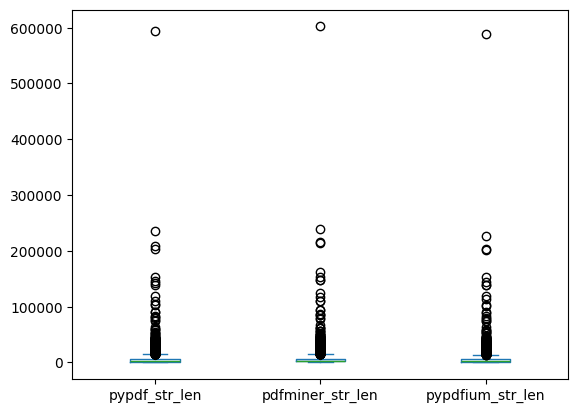

In [186]:
df_replaced[["pypdf_str_len", "pdfminer_str_len", "pypdfium_str_len"]].plot(kind="box")

In [195]:
# df_replaced = pd.read_parquet("../data/list_b3_pdf_comparison.parquet", engine="pyarrow")
df_replaced.reset_index(drop=True, inplace=True)

In [233]:
idx = 0

file = df_replaced.loc[idx,"file_name"]
pypdf_snippet = df_replaced.loc[idx,"pypdf_extraction"]
pdfminer_snippet = df_replaced.loc[idx,"pdfminer_extraction"]
pypdfium_snippet = df_replaced.loc[idx,"pypdfium_extraction"]

print(file)
# IFrame("./2023-11-09|187-2023-PRE-Ofício Circular.pdf", width=800, height=1000)

2023-11-09|187-2023-PRE-Ofício Circular.pdf


In [211]:
print(pypdf_snippet)

 
 
 
 
Este documento produz efeitos a partir da data de sua publicação, respeitados os prazos específicos de vigência, se houver.  
O teor deste documento confere com o original assinado, disponível na B3.  
Praça Antonio Prado, 48 – 01010 -901 – São Paulo, SP | Tel.: (11) 2565 -4000 – Fax: (11) 2565 -7737  1 
INFORMAÇÃO PÚBLICA – PUBLIC INFORMATION  9 de novembro de 2023  
187/2023-PRE 
OFÍCIO CIRCULAR  
Participantes do Listado B3  
Ref.: Alteração na Regra de Cadastro Automático de Vencimentos do 
Futuro de Cupom  de IPCA (DAP)  
Informamos que, a partir de 13/11/2023 , inclusive, ser á alterad a a regra para 
cadastro automático de vencimentos do Contrato Futuro de Cupom de IPCA 
(DAP) .  
A regra de cadastro automático de vencimentos foi revista, visando ampliar a 
abertura de novos vencimentos curtos de DAP, de 3 primeiros meses para 6 , 
conforme tabela abaixo  
Regra até 10/11/2023  
Regras do 
contrato  Cadastro automático  Cadastro pré-aprovado  Restrições  
Todos os meses 

In [212]:
print(pdfminer_snippet)

9 de novembro de 2023 
187/2023-PRE 

OFÍCIO CIRCULAR 

Participantes do Listado B3  

Ref.:  Alteração  na  Regra  de  Cadastro  Automático  de  Vencimentos  do 

Futuro de Cupom de IPCA (DAP) 

Informamos  que,  a  partir  de  13/11/2023,  inclusive,  será  alterada  a  regra  para 

cadastro  automático  de  vencimentos  do  Contrato  Futuro  de  Cupom  de  IPCA 

(DAP).  

A  regra  de  cadastro  automático  de  vencimentos  foi  revista,  visando  ampliar  a 

abertura  de  novos  vencimentos  curtos  de  DAP,  de  3  primeiros  meses  para  6, 

conforme tabela abaixo 

Regra até 10/11/2023 

Regras do 
contrato 

Cadastro automático 

Cadastro pré-aprovado 

Restrições 

3 primeiros meses. 

Até 15 anos 

Todos os meses 

1º vencimento janeiro (não 
contemplado nos 3 primeiros 
meses). 

•  Coincidente com pagamento de 
juros de NTN-B (fevereiro, maio, 
agosto e novembro). 

- 

• 
Até 15 anos: coincidente com 
vencimento de NTN-B (maio e 
agosto). 

Início de semestre. 

Este d

In [213]:
print(pypdfium_snippet)

Este documento produz efeitos a partir da data de sua publicação, respeitados os prazos específicos de vigência, se houver.
O teor deste documento confere com o original assinado, disponível na B3.
Praça Antonio Prado, 48 – 01010-901 – São Paulo, SP | Tel.: (11) 2565-4000 – Fax: (11) 2565-7737
1
INFORMAÇÃO PÚBLICA – PUBLIC INFORMATION
9 de novembro de 2023
187/2023-PRE
OFÍCIO CIRCULAR
Participantes do Listado B3 
Ref.: Alteração na Regra de Cadastro Automático de Vencimentos do 
Futuro de Cupom de IPCA (DAP)
Informamos que, a partir de 13/11/2023, inclusive, será alterada a regra para 
cadastro automático de vencimentos do Contrato Futuro de Cupom de IPCA 
(DAP). 
A regra de cadastro automático de vencimentos foi revista, visando ampliar a 
abertura de novos vencimentos curtos de DAP, de 3 primeiros meses para 6, 
conforme tabela abaixo
Regra até 10/11/2023
Regras do 
contrato
Cadastro automático Cadastro pré-aprovado Restrições
Todos os meses
3 primeiros meses.
1º vencimento janeiro (

In [234]:
idx = 2

file = df_replaced.loc[idx,"file_name"]
pypdf_snippet = df_replaced.loc[idx,"pypdf_extraction"]
pdfminer_snippet = df_replaced.loc[idx,"pdfminer_extraction"]
pypdfium_snippet = df_replaced.loc[idx,"pypdfium_extraction"]

# IFrame(f"{file}", width=800, height=1000)

In [26]:
print(pypdf_snippet)

 
 
 
 
Este documento produz efeitos a partir da data de sua publicação, respeitados os prazos específicos de vigência, se houver.  
O teor deste documento confere com o original assinado, disponível na B3.  
Praça Antonio Prado, 48 – 01010 -901 – São Paulo, SP | Tel.: (11) 2565 -4000 – Fax: (11) 2565 -7737  1 
INFORMAÇÃO PÚBLICA – PUBLIC INFORMATION  10 de outubro de 2023  
164/2023-PRE 
OFÍCIO CIRCULAR  
Participantes do Listado B3  
Ref.: Tratamento das Carteiras de Índices da B3 em virtude de OPA da BR 
Properties  S.A. 
A B3 informa que , em 16/10/2023 , às 15h, será realizad o o leilão  da Oferta 
Pública de Aquisição (OPA) de ações ordinárias  para cancelamento de registro da 
BR Properties  S.A. (Companhia).  De acordo com  Edital publicado em 15/09/2023 , 
a Slabs Investimentos Ltda.  (Ofertante ) se dispõe a adquirir até 17.205  (dezessete 
mil, duzentas e cinco ) ações ordinárias de emissão da Companhia (BRPR 3). Com 
base na Decisão CVM, descrita no item 2.4 do Edital, o s

In [27]:
print(pdfminer_snippet)

10 de outubro de 2023 
164/2023-PRE 

OFÍCIO CIRCULAR 

Participantes do Listado B3  

Ref.:  Tratamento das Carteiras de Índices da B3 em virtude de OPA da BR 

Properties S.A. 

A  B3  informa  que,  em  16/10/2023,  às  15h,  será  realizado  o  leilão  da  Oferta 

Pública de Aquisição (OPA) de ações ordinárias para cancelamento de registro da 

BR Properties S.A. (Companhia). De acordo com Edital publicado em 15/09/2023, 

a Slabs Investimentos Ltda. (Ofertante) se dispõe a adquirir até 17.205 (dezessete 

mil, duzentas e cinco) ações ordinárias de emissão da Companhia (BRPR3). Com 

base na Decisão CVM, descrita no item 2.4 do Edital, o sucesso da oferta deve ser 

considerado desde já atingido. 

Procedimentos nas carteiras de índices 

1.  Para os índices GPTW B3 (GPTW), Brasil Amplo BM&FBOVESPA (IBRA), Índice 

Imobiliário  (IMOB),  Índices  de  Ações  com  Tag  Along  Diferenciado  (ITAG)  e 

Small  Cap  (SMLL),  a  ação  BRPR3  será  excluída  da  carteira  teórica  após  o

## How to remove header and footer?
Assuming `pypdfium` library from now on.

In [28]:
# file = df_replaced.loc[idx,"file_name"]
# pypdf_snippet = df_replaced.loc[idx,"pypdf_extraction"]
# pdfminer_snippet = df_replaced.loc[idx,"pdfminer_extraction"]
# pypdfium_snippet = df_replaced.loc[idx,"pypdfium_extraction"]
file

'10_10_23|164-2023-PRE-Ofício Circular.pdf'

In [29]:
df_replaced.iloc[2,:]["published_title"]

'164-2023-PRE-Ofício Circular'

In [30]:
print(pypdfium_snippet)

Este documento produz efeitos a partir da data de sua publicação, respeitados os prazos específicos de vigência, se houver.
O teor deste documento confere com o original assinado, disponível na B3.
Praça Antonio Prado, 48 – 01010-901 – São Paulo, SP | Tel.: (11) 2565-4000 – Fax: (11) 2565-7737
1
INFORMAÇÃO PÚBLICA – PUBLIC INFORMATION
10 de outubro de 2023
164/2023-PRE
OFÍCIO CIRCULAR
Participantes do Listado B3 
Ref.: Tratamento das Carteiras de Índices da B3 em virtude de OPA da BR 
Properties S.A.
A B3 informa que, em 16/10/2023, às 15h, será realizado o leilão da Oferta 
Pública de Aquisição (OPA) de ações ordinárias para cancelamento de registro da 
BR Properties S.A. (Companhia). De acordo com Edital publicado em 15/09/2023, 
a Slabs Investimentos Ltda. (Ofertante) se dispõe a adquirir até 17.205 (dezessete 
mil, duzentas e cinco) ações ordinárias de emissão da Companhia (BRPR3). Com 
base na Decisão CVM, descrita no item 2.4 do Edital, o sucesso da oferta deve ser 
considerado d